In [1]:
%config Completer.use_jedi = False

c:\users\abhishek\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import xgboost

In [3]:
plt.style.use('ggplot')

#### Data

In [4]:
data_folder = "../data"

In [5]:
df_item_categories = pd.read_csv(os.path.join(data_folder, "item_categories.csv"))
df_items = pd.read_csv(os.path.join(data_folder, "items.csv"))
df_shops = pd.read_csv(os.path.join(data_folder, "shops.csv"))
df_sales_train = pd.read_csv(os.path.join(data_folder, "sales_train_v2.csv")) 
df_test = pd.read_csv(os.path.join(data_folder, "test.csv"))

In [6]:
df_sales_train["date"] = pd.to_datetime(df_sales_train.date, format="%d.%m.%Y")
df_sales_train["year"] = df_sales_train.date.dt.year
df_sales_train["month"] = df_sales_train.date.dt.month
df_sales_train["day"] = df_sales_train.date.dt.day

#### Adding features

In [7]:
df_sales_train = df_sales_train.merge(df_items[["item_id", "item_category_id"]], on="item_id", how="left")

In [8]:
df_test = df_test.merge(df_items[["item_id", "item_category_id"]], on="item_id", how="left")

In [9]:
import calendar
def get_weekend(month, year):
    days = [calendar.SATURDAY, calendar.SUNDAY]
    matrix = calendar.monthcalendar(year, month)
    num_days = sum(sum(bool(x[day]) for day in days) for x in matrix)
    return num_days

In [10]:
from itertools import product
years = [2013, 2014, 2015]
months = range(1, 13)
years, months = list(zip(*product(years, months)))
num_weekends = [get_weekend(month, year) for month, year in zip(months, years)] 
df_num_weekends = pd.DataFrame({"month": months, "year": years, "num_weekends": num_weekends})

In [11]:
df_sales_train = df_sales_train.merge(df_num_weekends, on=["month", "year"], how="left")

In [12]:
df_test["num_weekends"] = get_weekend(11, 2015)

In [21]:
df_conversion_rate = pd.read_csv("../data/conversion_rates.csv")

In [22]:
df_sales_train = df_sales_train.merge(df_conversion_rate, on=["month", 'year'], how="left")

In [24]:
df_test["rate"] =  df_conversion_rate.iloc[34].rate

In [25]:
occurance_shop_item = (pd.concat((df_sales_train[["shop_id", "item_id"]], df_test[["shop_id", "item_id"]]))
                       .groupby(["shop_id", "item_id"])
                       .size()
                       .apply(np.log1p)
                       .reset_index()
                       .rename(columns={0: "occurance"}))

In [26]:
df_sales_train = df_sales_train.merge(occurance_shop_item, on=["shop_id", "item_id"], how="left")

In [27]:
df_test = df_test.merge(occurance_shop_item, on=["shop_id", "item_id"], how="left")

In [28]:
df_category_size = (df_items
                    .groupby("item_category_id")
                    .size()
                    .apply(np.log1p)
                    .rename("category_size")
                    .reset_index())

In [29]:
df_sales_train = df_sales_train.merge(df_category_size, on="item_category_id", how="left")

In [30]:
df_test = df_test.merge(df_category_size, on="item_category_id", how="left")

In [31]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,item_category_id,num_weekends,rates,rate,occurance,category_size
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,37,8,30.2716,30.2716,1.098612,7.484930
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,58,8,30.2716,30.2716,1.098612,6.673298
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,58,8,30.2716,30.2716,1.098612,6.673298
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,58,8,30.2716,30.2716,0.693147,6.673298
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,56,8,30.2716,30.2716,2.397895,5.986452


**Lets not use `item price` for the first model**

In [32]:
df_sales_train = df_sales_train.drop(["date", "day", "item_price"], axis=1)

In [33]:
df_sales_train = (df_sales_train
                  .groupby(["date_block_num", "shop_id", "item_id"])
                  .aggregate({"item_cnt_day": "sum",
                              "year": "first",
                              "month": "first",
                              "item_category_id": "first",
                              "num_weekends": "first",
                              "rate": "first",
                              "occurance": "first",
                              "category_size": "first"})
                  .reset_index())

In [34]:
df_sales_train = df_sales_train.rename(columns={"item_cnt_day": "item_cnt_month"})

In [35]:
df_sales_train["item_cnt_month"] = df_sales_train.item_cnt_month.clip(0, 20)

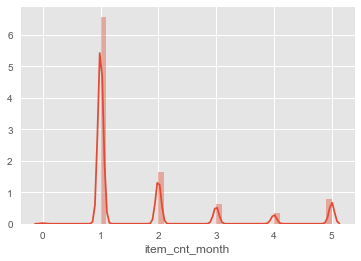

In [36]:
sns.distplot(df_sales_train.item_cnt_month.clip(0, 5))

In [37]:
X = df_sales_train.drop("item_cnt_month", axis=1)

In [38]:
y = df_sales_train.item_cnt_month

### XGBoost model

In [39]:
from xgboost import XGBRegressor, plot_importance

In [40]:
X_train = X[df_sales_train.date_block_num != 33]
y_train = y[df_sales_train.date_block_num != 33]

X_test = X[df_sales_train.date_block_num == 33]
y_test = y[df_sales_train.date_block_num == 33]

In [41]:
model = XGBRegressor(max_depth=8,
                     n_estimators=1000,
                     min_child_weight=300,
                     colsample_bytree=0.9,
                     subsample=0.9,
                     eta=0.15,
                     seed=42)

In [42]:
model.fit(X_train,
          y_train,
          eval_metric="rmse",
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True,
          early_stopping_rounds=10)

[0]	validation_0-rmse:2.84733	validation_1-rmse:2.82351
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.7209	validation_1-rmse:2.73112
[2]	validation_0-rmse:2.61312	validation_1-rmse:2.65782
[3]	validation_0-rmse:2.52204	validation_1-rmse:2.59578
[4]	validation_0-rmse:2.44572	validation_1-rmse:2.54696
[5]	validation_0-rmse:2.37994	validation_1-rmse:2.49652
[6]	validation_0-rmse:2.32392	validation_1-rmse:2.45267
[7]	validation_0-rmse:2.27687	validation_1-rmse:2.4232
[8]	validation_0-rmse:2.24231	validation_1-rmse:2.39317
[9]	validation_0-rmse:2.20817	validation_1-rmse:2.3736
[10]	validation_0-rmse:2.18422	validation_1-rmse:2.3464
[11]	validation_0-rmse:2.1586	validation_1-rmse:2.33039
[12]	validation_0-rmse:2.13702	validation_1-rmse:2.31447
[13]	validation_0-rmse:2.11839	validation_1-rmse:2.30465
[14]	validation_0-rmse:2.10241	validation_1-rmse:2.28657
[

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, eta=0.15, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.9)

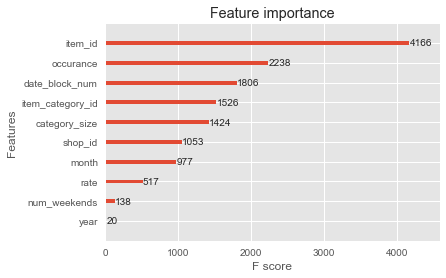

In [43]:
plot_importance(model)

In [44]:
df_test["date_block_num"] = 34
df_test["year"] = 2015
df_test["month"] = 11

In [32]:
df_sales_train.date_block_num.max()

33

In [54]:
train_shops_items = df_sales_train.groupby(["shop_id", "item_id"]).indices.keys()

In [55]:
df_test["present_in_train"] = df_test.apply(lambda x: (x.shop_id, x.item_id) in train_shops_items, axis=1)

In [56]:
y_pred = model.predict(df_test[X_train.columns])

**conservative approach** If a item-shop pair not present in the train data, then predict $0$ for it.

In [59]:
y_pred[~df_test.present_in_train] = 0

In [60]:
y_oct_pred = pd.read_csv("../data/october_pred.csv")

In [61]:
y_gdb_pred = y_oct_pred[:]

In [67]:
y_gdb_pred["item_cnt_month"] = ((y_gdb_pred.item_cnt_month + y_pred) / 2).clip_upper(20)

In [68]:
y_gdb_pred.to_csv("../data/gdb_plus_prev_month_pred_avg.csv", index=False)

In [69]:
y_gdb_pred.item_cnt_month.max()

20.0